In [1]:
%load_ext autoreload
%autoreload 2

In [46]:
import acnportal
import sklearn
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from copy import deepcopy
import warnings
import pytz
import time
import numpy as np
import pandas as pd
import pickle
from datetime import datetime, timedelta
from enum import Enum
from collections import namedtuple, defaultdict
import gzip
import random
import os
import json

from acnportal import acnsim
from acnportal import algorithms
from acnportal.acnsim.events import EventQueue
from acnportal.signals.tariffs.tou_tariff import TimeOfUseTariff
from acnportal.acnsim.events import GaussianMixtureEvents
from acnportal.contrib.acnsim import StochasticNetwork
from acnportal.acnsim.network import ChargingNetwork
from modified_adacharge import modified_adacharge
from modified_simulator import modified_simulator
from acnportal.acnsim import analysis
from upper_bound_estimator import SimpleRampdown

#### EV Charging Network

In [3]:
# This method won't take a evse_per_phase argument
def ev_fleet_level_2_network(transformer_cap=30):
    """ Configurable charging network for level-2 EVSEs connected line to line
        at 415 V.

    Args:
        transformer_cap (float): Capacity of the transformer feeding the network
          [kW]
        evse_per_phase (int): Number of EVSEs on each phase. Total number of
          EVSEs will be 3 * evse_per_phase.

    Returns:
        ChargingNetwork: Configured ChargingNetwork.
    """
    network = StochasticNetwork(early_departure=True)
    # network = ChargingNetwork()
    voltage = 415
    evse_type = 'AeroVironment'
    # evse_type = 'ClipperCreek'

    # Define the sets of EVSEs in the Caltech ACN.
    AB_ids = ['AB-{0}'.format(i) for i in range(2)]
    BC_ids = ['BC-{0}'.format(i) for i in range(3)]
    CA_ids = ['CA-{0}'.format(i) for i in range(3)]

    # print(AB_ids)

    # Add Caltech EVSEs
    for evse_id in AB_ids:
        network.register_evse(acnsim.get_evse_by_type(evse_id, evse_type), voltage, 30)
    for evse_id in BC_ids:
        network.register_evse(acnsim.get_evse_by_type(evse_id, evse_type), voltage, -90)
    for evse_id in CA_ids:
        network.register_evse(acnsim.get_evse_by_type(evse_id, evse_type), voltage, 150)

    # Add Caltech Constraint Set
    AB = acnsim.Current(AB_ids)
    BC = acnsim.Current(BC_ids)
    CA = acnsim.Current(CA_ids)

    # Define intermediate currents
    I3a = AB - CA
    I3b = BC - AB
    I3c = CA - BC
    I2a = (1 / 4) * (I3a - I3c)
    I2b = (1 / 4) * (I3b - I3a)
    I2c = (1 / 4) * (I3c - I3b)

    # Build constraint set
    primary_side_constr = transformer_cap * 1000 / 3 / 230
    print(primary_side_constr)
    secondary_side_constr = transformer_cap * 1000 / 3 / 415
    print(secondary_side_constr)
    network.add_constraint(I3a, secondary_side_constr, name='Secondary A')
    network.add_constraint(I3b, secondary_side_constr, name='Secondary B')
    network.add_constraint(I3c, secondary_side_constr, name='Secondary C')
    network.add_constraint(I2a, primary_side_constr, name='Primary A')
    network.add_constraint(I2b, primary_side_constr, name='Primary B')
    network.add_constraint(I2c, primary_side_constr, name='Primary C')

    return network

#### Simulation Parameters

In [24]:
# How long each time discrete time interval in the simulation should be.
PERIOD = 5  # minutes

# Voltage of the network.
VOLTAGE = 415  # volts

# Default maximum charging rate for each EV battery.
DEFAULT_BATTERY_POWER = 11 # kW

#### Generate synthetic events for simulation

In [25]:
# Generate synthetic events based on JPL data provided by ACN-Sim.
class CustomUnpicklerJPLdata(pickle.Unpickler):
    def find_class(self, module, name):
        if name == "sklearn.mixture.gaussian_mixture":
            return sklearn.mixture.GaussianMixture
        if name == "GaussianMixture":
            return sklearn.mixture.GaussianMixture
        return super().find_class(module, name)
    
def get_synth_events(sessions_per_day):
    gmm = CustomUnpicklerJPLdata(open('./data/jpl_weekday_40.pkl', "rb")).load()


    # Generate a list of the number of sessions to draw for each day.
    # This generates 30 days of charging demands.
    # num_evs = [0]*2 + [sessions_per_day]*5 + [0]*2 + [sessions_per_day]*5 + [0]*2 + \
    #           [sessions_per_day]*5 + [0]*2 + [sessions_per_day]*5 + [0]*2

    # Generate sessions for 1 day (weekdays only)
    num_evs = [0]*2 + [sessions_per_day]*1

    # Note that because we are drawing from a distribution, some sessions will be
    # invalid, we ignore these sessions and remove the corresponding plugin events.
    gen = GaussianMixtureEvents(pretrained_model=gmm, duration_min=0.08334)

    synth_events = gen.generate_events(num_evs, PERIOD, VOLTAGE, DEFAULT_BATTERY_POWER)
    return synth_events

In [27]:
# 20 EV sessions per weekday
events_20_ev = get_synth_events(20)

In [28]:
# Checking session details
session_copy = deepcopy(events_20_ev)
# print(type(session_copy))
session_list = list(session_copy.queue)
for session in session_list:
    print(session[0], session[1].ev._session_id, session[1].ev.departure, session[1].ev.requested_energy, session[1].event_type)

641 session_4 784 11.79292245938125 Plugin
653 session_16 701 2.6811904959990582 Plugin
652 session_5 732 12.191743366593705 Plugin
654 session_17 759 4.729969091184701 Plugin
675 session_10 782 4.16558126099345 Plugin
662 session_12 770 6.3862483712396285 Plugin
664 session_13 780 5.683778797574541 Plugin
671 session_7 721 13.967838896549715 Plugin
666 session_2 776 36.425453543500645 Plugin
746 session_19 791 8.10863084088773 Plugin
680 session_3 787 8.1920404492834 Plugin
672 session_11 770 5.181517196681105 Plugin
672 session_1 777 25.353241487141425 Plugin
675 session_6 725 15.44796995061063 Plugin
678 session_14 786 17.717964675992807 Plugin
715 session_0 774 9.918457794171033 Plugin
675 session_15 792 18.031558672398173 Plugin
680 session_8 751 7.488704102384242 Plugin
745 session_18 764 4.810659182478279 Plugin
777 session_9 791 6.9313082303061755 Plugin


#### Algorithms 

In [29]:
sch = {}
sch['Unctrl'] = algorithms.UncontrolledCharging()
sch['LLF'] = algorithms.SortedSchedulingAlgo(algorithms.least_laxity_first)
sch['RR'] = algorithms.RoundRobin(algorithms.first_come_first_served, continuous_inc=1)

cost_min_obj = [
                modified_adacharge.ObjectiveComponent(modified_adacharge.total_energy, 700),
                modified_adacharge.ObjectiveComponent(modified_adacharge.tou_energy_cost),
                modified_adacharge.ObjectiveComponent(modified_adacharge.quick_charge, 1e-6),
                modified_adacharge.ObjectiveComponent(modified_adacharge.equal_share, 1e-11),
                # modified_adacharge.ObjectiveComponent(modified_adacharge.total_energy, 500),
               ]

sch['MPC'] = modified_adacharge.AdaptiveSchedulingAlgorithm(cost_min_obj, solver="MOSEK", quantize=True, reallocate=False, peak_limit=200, max_recompute=1)



#### Run Simulations

In [30]:
sims = dict()

In [48]:
def run_experiment(alg_name, cap):
    """ Run simulation for the events defined previously and the specified
        network / algorithm / events.
    """
    # Timezone of the ACN we are using.
    # timezone = pytz.timezone('America/Los_Angeles')
    # Australian timezone for the experiment
    timezone = pytz.timezone('Australia/Melbourne')

    start = timezone.localize(datetime(2024, 1, 20))
    end = timezone.localize(datetime(2024, 1, 20))

    cn = ev_fleet_level_2_network(transformer_cap=cap)

    alg = deepcopy(sch[alg_name])
    # alg.max_rate_estimator = algorithms.SimpleRampdown()
    alg.max_rate_estimator = SimpleRampdown()
    alg.estimate_max_rate = True
    experiment_events = deepcopy(events_20_ev)
    signals = {'tariff': TimeOfUseTariff('sce_tou_ev_4_march_2019')}

    sim = modified_simulator.Simulator(cn, alg, experiment_events, start, period=PERIOD, signals=signals, verbose=False)
    print("Running...")
    start_simulation = time.time()
    sim.run()
    print(f"Run time: {time.time() - start_simulation}")

    return sim

In [32]:
warnings.simplefilter("ignore")

capacities = list(range(35, 71, 5))
alg_names = ["Unctrl", "LLF", "RR", "MPC"]

for cap in capacities:
    for alg_name in alg_names:
        config = (alg_name, cap)
        print(config)
        if config not in sims:
            sims[config] = run_experiment(*config)

('Unctrl', 35)
50.724637681159415
28.112449799196785
Running...
Run time: 0.2537658214569092
('LLF', 35)
50.724637681159415
28.112449799196785
Running...
Run time: 1.3592116832733154
('RR', 35)
50.724637681159415
28.112449799196785
Running...
Run time: 0.9500255584716797
('MPC', 35)
50.724637681159415
28.112449799196785
Running...
Run time: 10.007179260253906
('Unctrl', 40)
57.971014492753625
32.1285140562249
Running...
Run time: 0.2553393840789795
('LLF', 40)
57.971014492753625
32.1285140562249
Running...
Run time: 1.6468183994293213
('RR', 40)
57.971014492753625
32.1285140562249
Running...
Run time: 1.4837965965270996
('MPC', 40)
57.971014492753625
32.1285140562249
Running...
Run time: 15.253761768341064
('Unctrl', 45)
65.21739130434783
36.144578313253014
Running...
Run time: 0.23925328254699707
('LLF', 45)
65.21739130434783
36.144578313253014
Running...
Run time: 1.471304178237915
('RR', 45)
65.21739130434783
36.144578313253014
Running...
Run time: 1.0766992568969727
('MPC', 45)
65.

In [33]:
result_dir = "results/sims/paper_results"
if not os.path.exists("results/sims/paper_results"):
    os.makedirs("results/sims/paper_results")
    
for config, sim in sims.items():
    name = "results/sims/paper_results/{0}-{1}.json.gz".format(*config)
    if not os.path.exists(name):
        data = sim.to_json()
        with gzip.GzipFile(name, 'w') as fout:
            fout.write(json.dumps(data).encode('utf-8'))

#### Results Analysis

- Proportion of total energy requested which is delivered
- Maximum instantaneous power draw over the capacity of the system
- Average current imbalance

In [34]:
def calc_metrics(config, sim):
    metrics = {
        "Network Type": "three_phase",
        "Algorithm": config[0],
        "Capacity (kW)": config[1],
        "Energy Delivered (%)": analysis.proportion_of_energy_delivered(sim) * 100,
        "Max Utilization (%)": np.max(analysis.aggregate_power(sim)) / config[1] * 100,
        "Peak (kW)": np.max(analysis.aggregate_power(sim))
    }
    metrics["Current Unbalance"] = np.nanmean(analysis.current_unbalance(sim, ['Secondary {0}'.format(p) for p in 'ABC'], 'NEMA'))

    return metrics

In [35]:
metrics = pd.DataFrame(calc_metrics(config, sim) for config, sim in sims.items())

In [36]:
metrics.groupby(["Algorithm", "Network Type"])["Energy Delivered (%)"].describe()

,,count,mean,std,min,25%,50%,75%,max
Algorithm,Network Type,,,,,,,,
LLF,three_phase,8.0,86.227607,15.572041,62.121798,78.503225,92.887505,98.334629,98.890414
MPC,three_phase,8.0,82.330280,10.183910,59.636119,82.196960,84.387632,86.854901,93.508456
RR,three_phase,8.0,92.894767,5.892553,82.395018,90.389246,93.438295,98.216080,98.790691
Unctrl,three_phase,8.0,100.000000,0.000000,100.000000,100.000000,100.000000,100.000000,100.000000


In [37]:
metrics.groupby(["Algorithm", "Network Type"])["Peak (kW)"].describe()

,,count,mean,std,min,25%,50%,75%,max
Algorithm,Network Type,,,,,,,,
LLF,three_phase,8.0,27.521875,5.534240,19.505,23.8625,28.4300,31.9050,33.62
MPC,three_phase,8.0,27.183750,4.876910,19.920,24.2775,26.9750,30.6075,33.62
RR,three_phase,8.0,28.974375,5.928255,19.920,24.6925,30.0875,33.0000,37.56
Unctrl,three_phase,8.0,88.000000,0.000000,88.000,88.0000,88.0000,88.0000,88.00


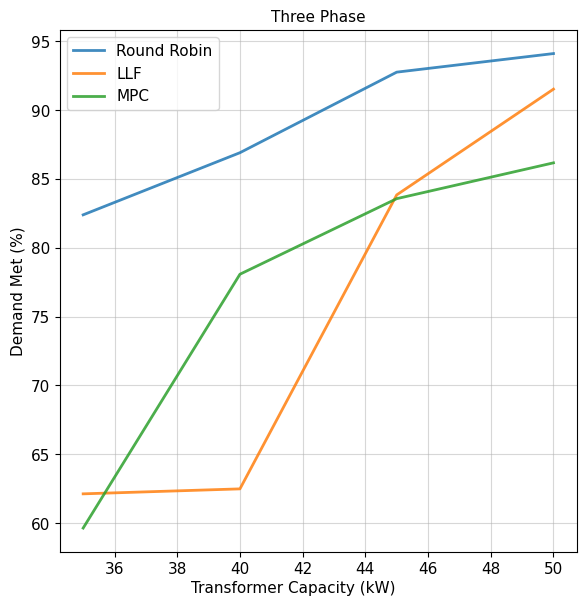

In [38]:
from matplotlib import cm
 
plt.style.use('default')

energy_delivered= metrics.pivot_table("Energy Delivered (%)", "Capacity (kW)", ["Network Type", "Algorithm"])
energy_delivered.rename(columns={'RR': 'Round Robin', 'MPC': 'MPC'}, inplace=True)

column_order = ['Round Robin', 'LLF', 'MPC']
cap_range = (30, 50)

cmap = cm.get_cmap('tab20')
li = 0
# label2color = {'FCFS': cmap(0+li), 'EDF': cmap(2+li), 'LLF': cmap(4+li), 'Round Robin': cmap(6+li), 
#                'Offline Optimal': cmap(8), 'MPC': cmap(9)}

label2color = {'Round Robin': cmap(0+li), 'LLF': cmap(2+li), 'MPC': cmap(4)}

style = {
    "color": [label2color[col] for col in column_order],
    "style": ["-"]*5 + ["*"],
    "linewidth": 2,
    "alpha": .85,
    # "marker": ["."]*5 + [None],
    #"fillstyle": "none",
    "legend": False,
}

plt.rc('text', usetex=False)
plt.rcParams.update({'font.size': 11})

fig, ax = plt.subplots(nrows=1, figsize=(7, 2), sharey=True)
energy_delivered["three_phase"][column_order].loc[cap_range[0]:cap_range[1]].plot(ax=ax, **style)
ax.legend(loc="best")

ax.set_title("Three Phase", fontsize=11)

fig.text(0.5, 0, "Transformer Capacity (kW)", ha='center')

ax.set_xlabel("")

ax.set_ylabel("Demand Met (%)")

ax.grid(alpha=0.5)
fig = plt.gcf()
fig.set_size_inches(6, 6)
plt.tight_layout()

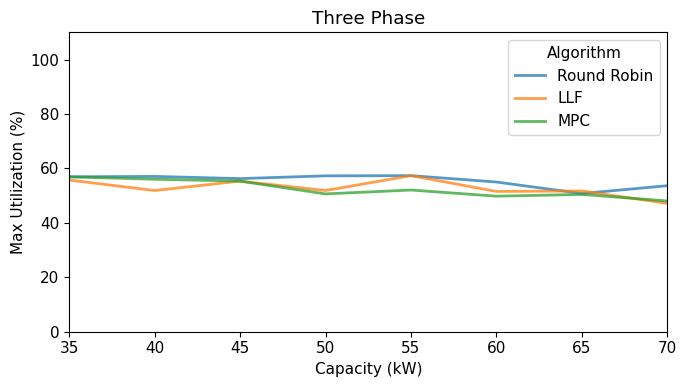

In [39]:
utilization = metrics.pivot_table("Max Utilization (%)", "Capacity (kW)", ["Network Type", "Algorithm"])
utilization.rename(columns={'RR': 'Round Robin', 'MPC': 'MPC'}, inplace=True)
column_order = ['Round Robin', 'LLF', 'MPC']
cap_range = (35, 70)

fig, axes = plt.subplots(1, figsize=(7, 4), sharey=True)
utilization["three_phase"][column_order].loc[cap_range[0]:cap_range[1]].plot(linewidth=2, alpha=0.75, ax=axes)
axes.set_xlim(35, 70)
axes.set_ylim(0, 110)

axes.set_ylabel('Max Utilization (%)')
axes.set_title("Three Phase")

plt.tight_layout()

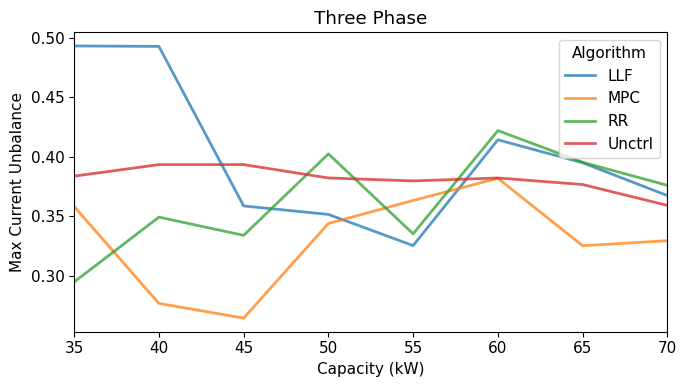

In [40]:
current_unbalance = metrics.pivot_table("Current Unbalance", "Capacity (kW)", ["Network Type", "Algorithm"])
fig, ax = plt.subplots(1, figsize=(7, 4), sharey=True)
current_unbalance["three_phase"].plot(linewidth=2, alpha=0.75, ax=ax)
ax.set_xlim(35, 70)
ax.set_ylabel("Max Current Unbalance")
ax.set_title("Three Phase")
plt.tight_layout()

##### Line Currents

In [41]:
def plot_line_currents(sims, names, start, length):
  fig, axes = plt.subplots(2, len(sims), sharey='row', sharex=True, figsize=(7, 6))
  axes[0,0].set_xlim(start, start+length)
  fig.subplots_adjust(wspace=0.07, hspace=0.07)
  for i, sim in enumerate(sims):
    cc = analysis.constraint_currents(sim)
    for line in 'ABC': 
      axes[0, i].plot(cc['Primary {0}'.format(line)], label='Primary {0}'.format(line), linewidth=2)
      axes[1, i].plot(cc['Secondary {0}'.format(line)], label='Secondary {0}'.format(line), linewidth=2)

    axes[1, i].axhline(120/3, color='gray', linestyle='--')
    axes[0, i].axhline(60/3, color='gray', linestyle='--')
    axes[0, i].set_title(names[i])
    
  axes[0,-1].legend()
  axes[1,-1].legend()
  plt.show()
  return fig

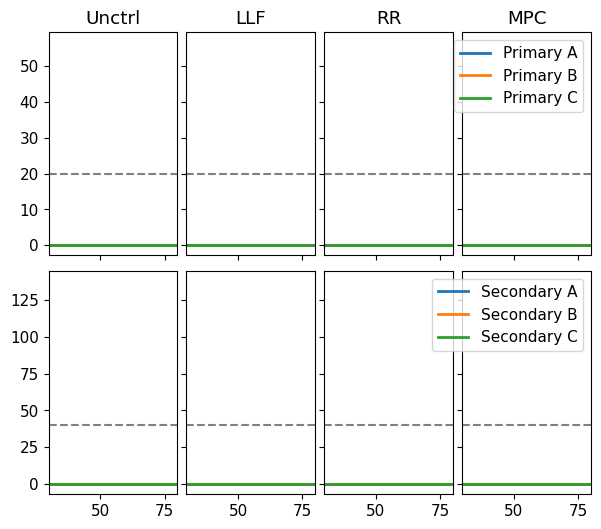

In [42]:
alg_order = ["Unctrl", "LLF", "RR", "MPC"]
# print(len([sims[alg, 50] for alg in alg_order]))
fig = plot_line_currents([sims[alg, 45] for alg in alg_order], alg_order, 30, 50)

#### EV Charging Profile

In [43]:
def plot_ev_charging(sim, ev, ax, label, label_auto_place=False):
    evse_index = sim.network.station_ids.index(ev.station_id)
    session_len = ev.departure - ev.arrival
    x = [sim.start + timedelta(minutes=5 * ev.arrival) + timedelta(minutes=5*i) for i in range(session_len)]
    ax.step(x, sim.charging_rates[evse_index][ev.arrival:ev.departure],
            label=label, linewidth=2)
    if label_auto_place:
        ax.legend()
    else:
        ax.text(0.02, 0.9, label, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes)

def plot_profiles(sims, cap, ev, end=None, label_auto_place=False):
    fig, axes = plt.subplots(3, 1, sharey=True, sharex=True, figsize=(7, 6))

    x_min = sim.start + timedelta(minutes=5 * ev.arrival)
    x_max = end if end is not None else sim.start + timedelta(minutes=5 * ev.departure)
    axes[0].set_xlim(x_min, x_max)
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    fig.autofmt_xdate()

    axes[0].set_ylim(0, 50)
    axes[0].set_yticks([0, 25, 50])
    
    plt.subplots_adjust(hspace=.2)
    fig.text(0.035, 0.55, 'Charging Current (A)', va='center', rotation='vertical')
    print(ev.session_id)
    for i, alg_name in enumerate(["RR", "LLF", "MPC"]):
        label = alg_name if alg_name != "Offline" else "Offline Optimal"
        plot_ev_charging(sims[alg_name, cap], ev, axes[i], label=label, label_auto_place=label_auto_place)
        axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['top'].set_visible(False)
    return fig

session_12


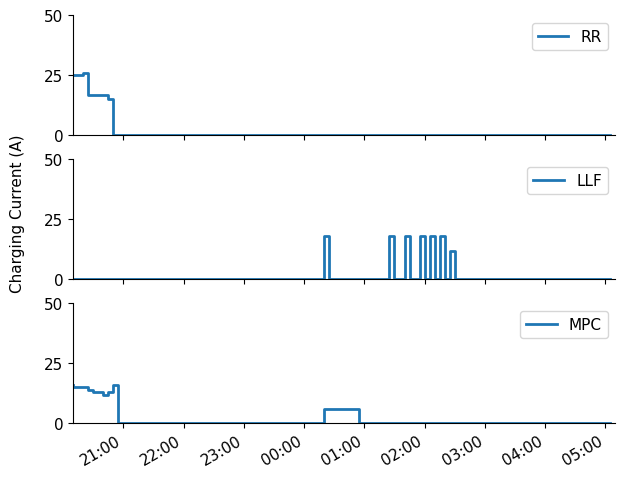

In [45]:
ev = random.choice(list(sims["MPC", cap].ev_history.values()))
cap = 55
plot_profiles(sims, cap, ev, label_auto_place=True)
plt.show()